# RealNVP (*In progress*)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**
- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184?keywords=generative+deep+learning,+2nd+edition&qid=1684708209&sprefix=generative+de,aps,93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/06_normflow/01_realnvp/realnvp.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as sk_datasets

import torch
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader

import torchinfo

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", DEVICE)

device:  cuda


## 0. Training Parameters

In [2]:
NUM_SAMPLES = 3_000
COULPING_LAYERS = 2
INPUT_DIM = 2
HIDDEN_DIM = 256
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 300

## 1. Preparing Moon dataset

The shape of moon dataset (3000, 2)


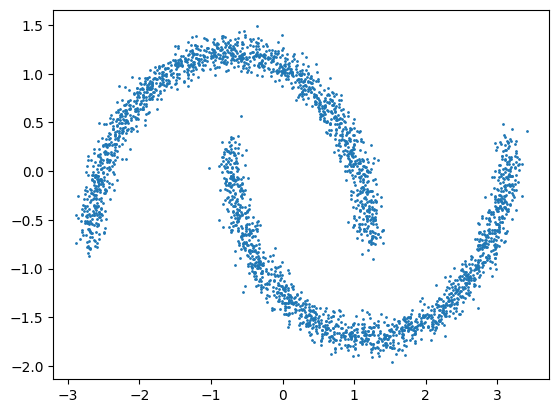

In [3]:
data = sk_datasets.make_moons(NUM_SAMPLES, noise=5e-2)[0].astype("float32")
print("The shape of moon dataset", data.shape)
# data normalization
mean = data.mean()
std = data.std()
moon_data = (data - mean) / (std ** 2)
# visualize data
plt.scatter(moon_data[:, 0], moon_data[:, 1], s=1.0)
plt.show()

In [4]:
# creating dataloader
moon_loader = DataLoader(dataset=moon_data, batch_size=BATCH_SIZE, shuffle=True)

## 2. Building RealNVP

Building backbone layer

In [5]:
def get_backbone_layer(n_layers=5, output_activation=nn.Tanh):
    dims = [INPUT_DIM] + [HIDDEN_DIM] * (n_layers - 1) + [INPUT_DIM]
    layers = []
    for i in range(n_layers):
        layers.append(nn.Linear(dims[i], dims[i+1]))
        if i != n_layers - 1: 
            layers.append(nn.ReLU())
        else:
            layers.append(output_activation())
    return nn.Sequential(*layers)

In [6]:
torchinfo.summary(get_backbone_layer(), input=(1, 2))

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            768
├─ReLU: 1-2                              --
├─Linear: 1-3                            65,792
├─ReLU: 1-4                              --
├─Linear: 1-5                            65,792
├─ReLU: 1-6                              --
├─Linear: 1-7                            65,792
├─ReLU: 1-8                              --
├─Linear: 1-9                            514
├─Tanh: 1-10                             --
Total params: 198,658
Trainable params: 198,658
Non-trainable params: 0

Implement RealNVP model

In [28]:
class RealNVP(nn.Module):

    num_couplings = COULPING_LAYERS
    device = DEVICE
    
    def __init__(self):
        super().__init__()
        # Create multivariate normal distribution
        loc = torch.zeros(2, device=self.device, requires_grad=False)
        cov = torch.eye(2, device=self.device, requires_grad=False)
        self.distribution = distributions.MultivariateNormal(loc = loc, 
                                                             covariance_matrix = cov)
        
        mask = torch.tensor([[0, 1], [1, 0]] * (self.num_couplings // 2), dtype=torch.float32)
        self.register_buffer("mask", mask)
        
        self.t = nn.ModuleList([get_backbone_layer(output_activation=nn.Identity)
                                for _ in range(self.num_couplings)])
        self.s = nn.ModuleList([get_backbone_layer(output_activation=nn.Tanh)
                                for _ in range(self.num_couplings)])


    # f(x) forward process
    def f(self, x):
        log_det_inv = x.new_zeros(x.shape[0])
        z = x
        for i in reversed(range(len(self.t))):
            z_masked = self.mask[i] * z
            s = self.s[i](z_masked) * (1 - self.mask[i])
            t = self.t[i](z_masked) * (1 - self.mask[i])
            z = z_masked + (1 - self.mask[i]) * (z - t) * torch.exp(-s)
            log_det_inv -= s.sum(dim=1)
        return z, log_det_inv

    
    # g(z) backward process
    @torch.no_grad()
    def g(self, z):
        x = z
        for i in range(len(self.s)):
            x_masked = self.mask[i] * x
            s = self.s[i](x_masked) * (1 - self.mask[i])
            t = self.t[i](x_masked) * (1 - self.mask[i])
            x = x_masked + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    # forward pass
    def forward(self, data=None, num_samples=None):
        if self.training:
            assert data is not None, "Training data should be provided" 
            print("Training mode")
            z, log_det = self.f(data)
            return self.distribution.log_prob(z) + log_det
        else:
            assert num_samples is not None, "Number of samples should be provided"
            print("Inferencing mode")
            z = self.prior.sample((num_samples, 1))
            x = self.g(z)
            return x

In [29]:
torchinfo.summary(RealNVP(), input=(1, 2))

Layer (type:depth-idx)                   Param #
RealNVP                                  --
├─ModuleList: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  768
│    │    └─ReLU: 3-2                    --
│    │    └─Linear: 3-3                  65,792
│    │    └─ReLU: 3-4                    --
│    │    └─Linear: 3-5                  65,792
│    │    └─ReLU: 3-6                    --
│    │    └─Linear: 3-7                  65,792
│    │    └─ReLU: 3-8                    --
│    │    └─Linear: 3-9                  514
│    │    └─Identity: 3-10               --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-11                 768
│    │    └─ReLU: 3-12                   --
│    │    └─Linear: 3-13                 65,792
│    │    └─ReLU: 3-14                   --
│    │    └─Linear: 3-15                 65,792
│    │    └─ReLU: 3-16                   --
│    │    └─Linear: 3-17                 65,792


In [30]:
## Test session
model = RealNVP().to(DEVICE)
test_data = next(iter(moon_loader)).to(DEVICE)
model(test_data)

Training mode


tensor([-3.0548, -4.9172, -2.6927, -3.1086, -2.6838, -4.2668, -2.2317, -6.1777,
        -6.3832, -2.3021, -2.7282, -2.4845, -2.3215, -3.6138, -3.6445, -5.1620,
        -2.5407, -2.0528, -2.8020, -7.2354, -4.9466, -2.2505, -2.0613, -5.8047,
        -3.0767, -4.6431, -5.0663, -2.6236, -6.6967, -6.4184, -6.0569, -7.3826,
        -7.2410, -2.6552, -3.1224, -2.6906, -3.2541, -2.1586, -2.8190, -2.3286,
        -2.3457, -2.4383, -5.5783, -5.8200, -3.8742, -2.3044, -5.7299, -2.3441,
        -2.4135, -5.8393, -2.1749, -4.2888, -5.2903, -2.5714, -2.8872, -5.4816,
        -5.4677, -4.8724, -3.6423, -5.1137, -2.2181, -3.6201, -4.7315, -2.2968,
        -6.3862, -3.8070, -2.2881, -2.4365, -3.7311, -2.9448, -3.2764, -7.4209,
        -5.5970, -2.1513, -3.0398, -3.4026, -3.4259, -2.8734, -2.4971, -2.8318,
        -4.1642, -2.3182, -2.1048, -6.7498, -2.3163, -4.7572, -5.3836, -2.2567,
        -3.6359, -5.3766, -3.1695, -2.5563, -2.2837, -2.8970, -4.0437, -6.4510,
        -6.3029, -2.4356, -2.3325, -2.44